In [1]:
%%capture
!pip3 install bertviz
!pip3 install wandb
!pip3 install optuna
!pip3 install datasets
!pip3 install evaluate

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import wandb

import torch
from sklearn.preprocessing import MultiLabelBinarizer
import optuna

from datasets import DatasetDict, load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from bertviz import head_view, model_view

import os

from torch.utils.data import DataLoader, Subset
import re

import torchvision

import torch.nn.functional as F

import evaluate

2022-09-07 14:50:55.357188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 14:50:55.358319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 14:50:55.359033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 14:50:55.361325: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
notebook_environment = 'kaggle'

In [4]:
report_to="none"

if report_to == "wandb":
    wandb.init(project="thesis")

In [5]:
def get_dataset(notebook_environment, path):
  if notebook_environment == 'kaggle':
    return pd.read_json(os.path.join('../input/dataset',path))
  elif notebook_environment == 'colab':
    from google.colab import drive
    drive.mount('/gdrive')
    return pd.read_json(os.path.join('/gdrive/My Drive/tesi/dataset/scripts/', path))

df = get_dataset(notebook_environment, 'dataset.json')

In [6]:
df = df[df['label'].apply(lambda x: not 'other' in x)] # remove docs with 'other' label

In [7]:
labels_list = ['Corporate',
 'Crime',
 'Cybersecurity',
 'Economics',
 'Environment',
 'Geopolitics',
 'Healthcare',
 'Infrastructure, Transportation and Energy',
 'Military',
 'Politics',
 'Terrorism']

#Model

In [8]:
model_name = "distilbert-base-uncased"

# model = AutoModelForSequenceClassification.from_pretrained(model_name, problem_type="multi_label_classification", num_labels=len(labels_list), output_attentions=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, problem_type="multi_label_classification", num_labels=len(labels_list))
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

#EDA

In [9]:
def plot_corr_labels(df):
  corr = pd.DataFrame(data=[[0]*len(labels_list)]*len(labels_list),columns=labels_list, index=labels_list)
  for labels in df['label']:
      for l1, l2 in [(l1,l2) for l1 in labels for l2 in labels]:
          corr[l1][l2] += 1

  corr = corr.div(corr.max(axis=1), axis=0)
  sns.heatmap(corr)

def plot_freq_labels(df):
  freq = df['label'].map(str).value_counts()
  plt.figure(figsize=(40,5))
  plt.bar(freq.keys()[:10], freq.values[:10])

def compute_len_docs(df):
  tokenized_dataset = df['text'].map(lambda x: tokenizer(x, truncation=False))
  df['length_doc'] = [len(tokenizer.convert_ids_to_tokens(doc['input_ids'])) for doc in tokenized_dataset]

In [10]:
compute_len_docs(df)

Token indices sequence length is longer than the specified maximum sequence length for this model (1296 > 512). Running this sequence through the model will result in indexing errors


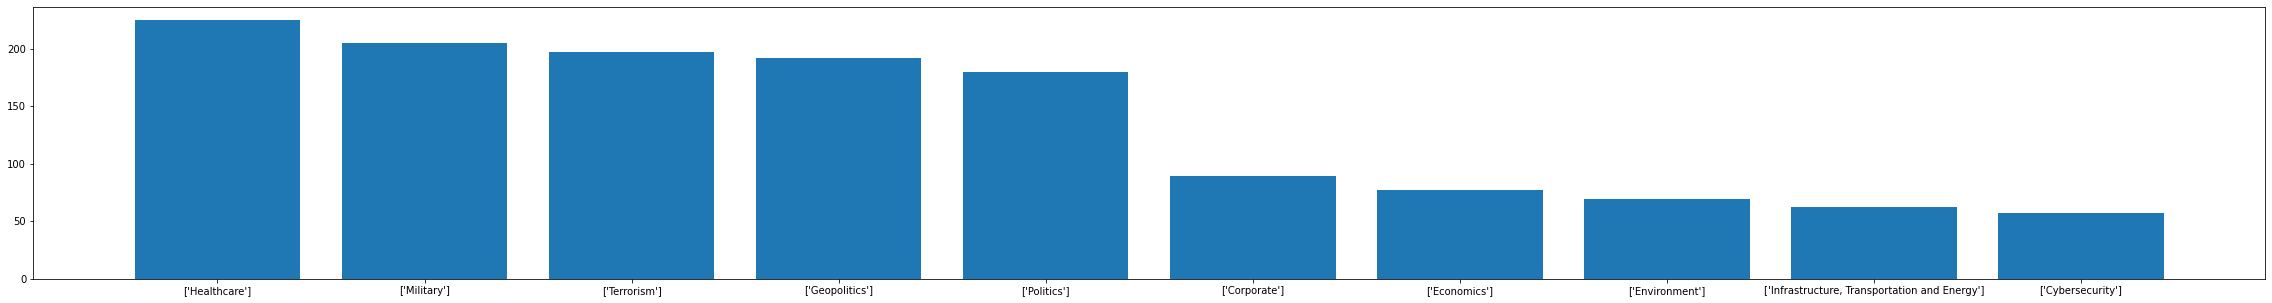

In [11]:
plot_freq_labels(df)

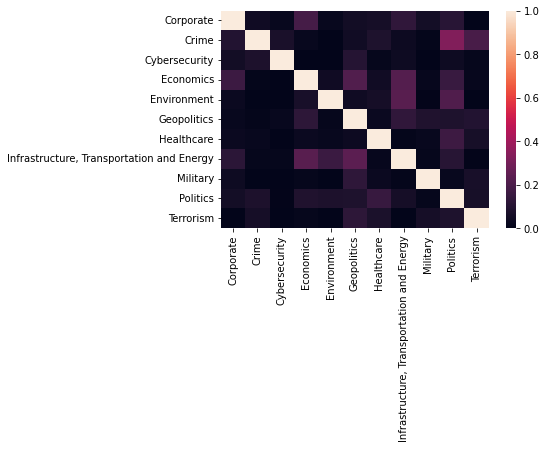

In [12]:
plot_corr_labels(df)

<AxesSubplot:xlabel='length_doc', ylabel='Count'>

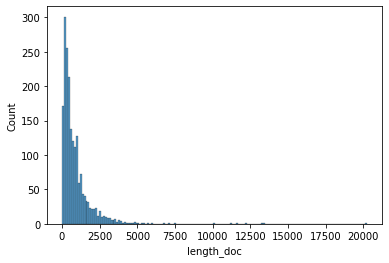

In [13]:
sns.histplot(df['length_doc'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='length_doc'>

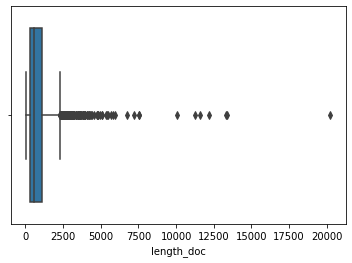

In [14]:
sns.boxplot(df['length_doc'])

In [15]:
print('Number of docs: {}'.format(len(df)))
print('Number of docs with > 512 tokens: {}'.format(len([x for x in df['length_doc'] if x > 512])))

Number of docs: 1954
Number of docs with > 512 tokens: 1057


## Outliers: long documents

Outliers:
	N: 248
	Url: 35 {'https://mondediplo.com', 'https://jihadintel.meforum.org', 'https://warontherocks.com', 'https://icct.nl', 'https://www.realinstitutoelcano.org', 'https://www.defensenews.com', 'https://www.theatlantic.com', 'https://hbr.org', 'https://www.bbc.com', 'https://cybernews.com', 'https://www.worldbank.org', 'https://ecfr.eu', 'https://www.foreignaffairs.com', 'https://www.nbcnews.com', 'https://www.theguardian.com', 'https://www.atlanticcouncil.org', 'https://www.politico.com', 'https://www.ispionline.it', 'https://www.businessinsider.com', 'https://www.csis.org', 'https://www.politico.eu', 'https://bitcoinmagazine.com', 'https://foreignpolicy.com', 'https://apnews.com', 'https://www.criticalthreats.org', 'https://www.centerforhealthsecurity.org', 'https://www.chathamhouse.org', 'https://www.reuters.com', 'http://jihadintel.meforum.org', 'https://www.huffpost.com', 'https://edition.cnn.com', 'https://www.rand.org', 'https://www.iea.org', 'https://www.fpri.org', 

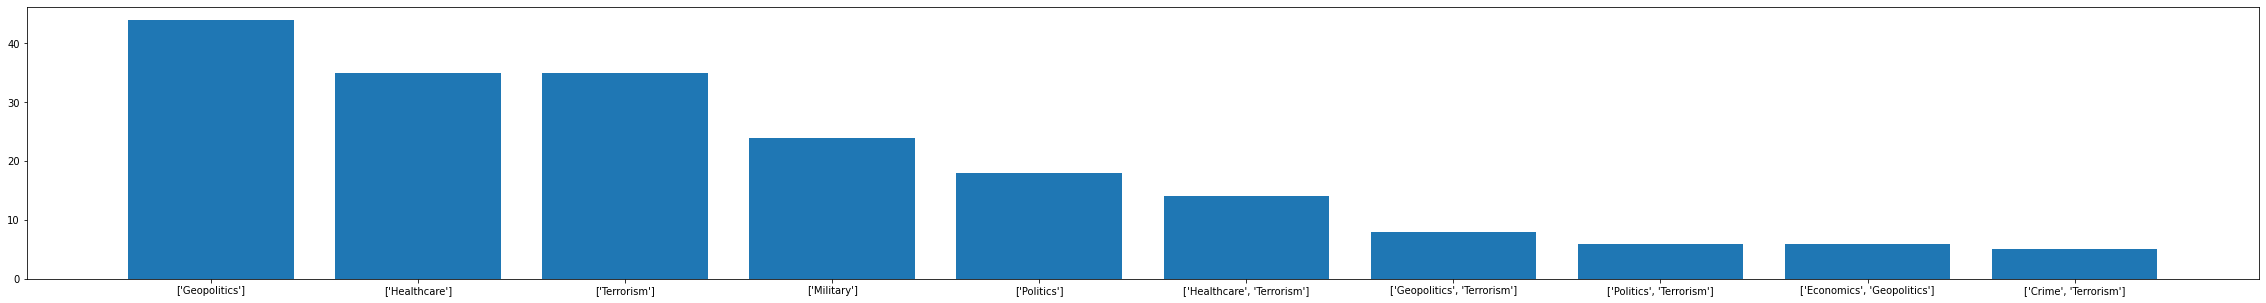

In [16]:
regex_obj = re.compile('http[s]?://(www)?.([\w\-\.]+)')

outliers = df[df['length_doc'].apply(lambda x: x >= 1750)]
labels = set([l for labels in outliers['label'] for l in labels])
urls = set([regex_obj.match(url).group() for url in outliers['url']])

print('Outliers:')
print('\tN:', len(outliers))
print('\tUrl:', len(urls), urls)
print('\tLabels:', len(labels), labels)

plot_freq_labels(outliers)

Outliers:
	N: 1706
	Url: 70 {'https://mondediplo.com', 'https://www.ansa.it', 'https://jihadintel.meforum.org', 'https://icct.nl', 'https://www.wired.com', 'https://www.armyrecognition.com', 'https://www.realinstitutoelcano.org', 'https://www.defensenews.com', 'https://climateandsecurity.org', 'https://www.armytimes.com', 'https://www.theatlantic.com', 'https://www.investopedia.com', 'https://www.defense.gov', 'https://www.c4isrnet.com', 'https://www.memri.org', 'https://www.who.int', 'https://www.bbc.com', 'https://greydynamics.com', 'https://www.brookings.edu', 'https://cybernews.com', 'https://hbr.org', 'https://www.worldbank.org', 'https://www.iaea.org', 'https://ecfr.eu', 'https://www.gmfus.org', 'https://irena.org', 'https://www.energyintel.com', 'https://eng.mil.ru', 'https://www.realclearenergy.org', 'https://www.foreignaffairs.com', 'https://cepa.org', 'https://www.nbcnews.com', 'https://www.airforcetimes.com', 'https://www.theguardian.com', 'https://english.news.cn', 'https:/

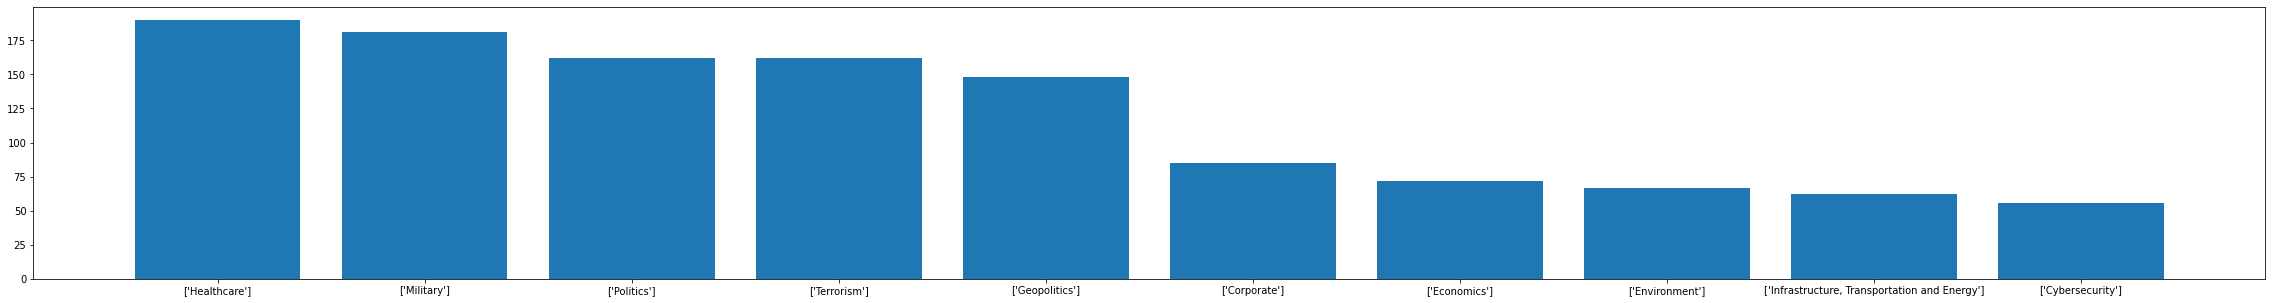

In [17]:
regex_obj = re.compile('http[s]?://(www)?.([\w\-\.]+)')

outliers = df[df['length_doc'].apply(lambda x: x < 1750)]
labels = set([l for labels in outliers['label'] for l in labels])
urls = set([regex_obj.match(url).group() for url in outliers['url']])

print('Outliers:')
print('\tN:', len(outliers))
print('\tUrl:', len(urls), urls)
print('\tLabels:', len(labels), labels)

plot_freq_labels(outliers)

<AxesSubplot:ylabel='Count'>

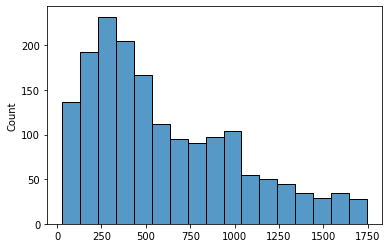

In [18]:
sns.histplot([d for d in df['length_doc'] if d < 1750])

#Load Dataset

In [19]:
# 60% - train set, 20% - validation set, 20% - test set
train, test = \
              np.split(df.sample(frac=1, random_state=42),
                       [int(.8*len(df))])

In [20]:
train_dataset = Dataset.from_dict(train)
test_dataset = Dataset.from_dict(test)
dataset = DatasetDict({"train":train_dataset,"test":test_dataset})

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'url', 'source', 'label', 'Comments', 'length_doc'],
        num_rows: 1563
    })
    test: Dataset({
        features: ['id', 'text', 'url', 'source', 'label', 'Comments', 'length_doc'],
        num_rows: 391
    })
})

Converts the labels into a binary matrix (samples x classes) indicating the presence of a class label.

In [22]:
dataset = dataset.rename_column("label","label_names")

In [23]:
mlb = MultiLabelBinarizer(classes=labels_list).fit(None)

def tokenize_function(data):
    out = tokenizer(data['text'], padding="max_length", truncation=True)
    out["labels"] = mlb.transform(data["label_names"]).astype(np.float32)  # must be float
    return out

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#Train

In [24]:
accuracy", "recall", "precision", "f1"])

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.where(logits > 0, 1, 0) # np.where(sigmoid(logits) > 0.5, 1, 0)

    for refs, pred in zip(labels,predictions):
      metric.add_batch(references=refs, predictions=pred)

    results = metric.compute(average="macro")

    return results

In [25]:
batch_size = 1
epochs = 2
learning_rate=2e-5
weight_decay=4e-5

training_args = TrainingArguments(
    output_dir="/kaggle/working/test_trainer",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to=report_to,
    save_strategy="epoch",
    metric_for_best_model=f1_metric.name,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-06,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    warmup_ratio=0.1

)

In [26]:
use_optuna = False

if use_optuna:

  def objective(trial: optuna.Trial, training_args):
    learning_rate = trial.suggest_float('learning_rate', low=2e-5, high=5e-5, log=True)
    weight_decay = trial.suggest_float('weight_decay', 4e-5, 0.01, log=True)

    training_args.learning_rate = learning_rate
    training_args.weight_decay = weight_decay

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['test'],
        compute_metrics=compute_metrics
    )

    trainer.train()
    result = trainer.evaluate(tokenized_datasets['test'])
    
    return result['eval_f1']

  study = optuna.create_study(study_name='hyper-parameter-search', direction='maximize')
  study.optimize(func=lambda trial: objective(trial, training_args), n_trials=1)

  print("best value:", study.best_value) 
  print(study.best_trial)

  plot_optimization_history(study)
  plot_param_importances(study)

In [27]:
if not use_optuna:
  class CustomLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
      alpha = 0.25
      gamma = 2

      outputs = model(**inputs)

      targets = inputs.get("labels")
      logits = outputs.get("logits")

      loss = torchvision.ops.sigmoid_focal_loss(logits, targets, reduction = "mean")

      return (loss, outputs) if return_outputs else loss

  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics
    )

  trainer.train()
  result = trainer.evaluate(tokenized_datasets['test'])

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: label_names, source, id, text, url, Comments, length_doc. If label_names, source, id, text, url, Comments, length_doc are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1563
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 3126


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 418.56 MiB already allocated; 13.75 MiB free; 420.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# BertViz

In [ ]:
use_bertviz = False

if use_bertviz:
  sentence_a = "The cat sat on the mat"
  inputs = tokenizer(sentence_a, padding="max_length", truncation=True, return_tensors='pt')
  input_ids = inputs['input_ids']
  token_type_ids = inputs['token_type_ids']
  attention = model(input_ids.to(device), token_type_ids=token_type_ids.to(device))[-1]
  input_id_list = input_ids[0].tolist() # Batch index 0
  tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [ ]:
if use_bertviz:
  head_view(attention, tokens)

In [ ]:
if use_bertviz:
  model_view(attention, tokens)

In [ ]:
if use_bertviz:
  show(model, model_type, tokenizer, sentence_a, layer=4, head=3)

# Inference

In [ ]:
def get_dataset(notebook_environment, path):
  if notebook_environment == 'kaggle':
    return pd.read_json(os.path.join('../kaggle/input',path))
  elif notebook_environment == 'colab':
    from google.colab import drive
    drive.mount('/gdrive')
    return pd.read_json(os.path.join('/gdrive/My Drive/tesi/dataset', path))

remaining_df = get_dataset(notebook_environment, 'remaining/20_8_22.json')
remaining = Dataset.from_pandas(remaining_df)

In [ ]:
batch_size = 1

tokenized_datasets = remaining.map(lambda x: tokenizer(x['text'], padding="max_length", truncation=True), batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'text', 'url', 'source', 'label', 'Comments'])
tokenized_datasets.set_format("torch")

In [ ]:
model.eval()

predictions=[]
logits_list = []

dataloader = DataLoader(tokenized_datasets, shuffle=True, batch_size=batch_size)
for batch in dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

      logits = outputs.logits
      predictions += torch.where(logits > 0, 1, 0) # np.where(sigmoid(logits) > 0.5, 1, 0)
      logits_list += logits.cpu().tolist()

In [ ]:
predictions = [[labels_list[i]  if prediction[i] == 1 else 'None' for i in range(len(prediction))] for prediction in predictions]

In [ ]:
remaining_df['predictions'] = predictions
remaining_df['logits'] = logits_list

In [ ]:
remaining_df

In [ ]:
def dump_dataset(notebook_environment, df, path):
  if notebook_environment == 'kaggle':
    return df.to_json(os.path.join('../kaggle/input',path))
  elif notebook_environment == 'colab':
    from google.colab import drive
    drive.mount('/gdrive')
    df.to_json(os.path.join('/gdrive/My Drive/tesi/dataset', path))

dump_dataset(notebook_environment, remaining_df, './inference.json')